![Galileo](https://github.com/RainieroPV/Ciencia-de-Datos-en-Python/blob/main/images/GalileoLogo.PNG?raw=true  "Galileo")
> #### Ciencia de Datos en Python, Seccion V
>>  Rainiero Jose Parrales Vargas  
>>  20032022.

# Proyecto Final
___

1. Cargar las librerias necesarias

In [281]:
import pandas  as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import datasets, linear_model

1. Cargar el archivo  - Este lo maneje con una subcarpeta de donde esta el proyeto

In [161]:
# Numpy
#-------------------------------------------------------------------------------

DataC = np.load('./proyecto_data/proyecto_training_data.npy')

#-------------------------------------------------------------------------------

## Slice
1. Lo maneje como pandas ya que hay funciones rapidas para el calculo
2. Calculo el slide del 80% y 20%

## Analisis exploratorio de datos
+ Para cada variable en el dataset calcular:
+ Media
+ Valor maximo
+ Valor minimo
+ Rango
+ Desviacion estandar.

In [263]:
# Pandas          
#-------------------------------------------------------------------------------
dfPandas = pd.DataFrame(DataC) # usando Pandas
dfPandas.columns = ['SalePrice','OverallQual','1stFlrSF','TotRmsAbvGrd','YearBuilt','LotFrontage'] # pongo titulos a las columnas

filas = int(len(dfPandas)*(80/100)) # calculo el 80%
Modelo = dfPandas[:filas] # Hago la particion del modelo
Validacion = dfPandas[filas:] # Hago la particion de la alidacion
calculoModelo = Modelo.describe(include = 'all') # con la funcion describe puedo calculas las variables solicitadas
# filtro lo que quiero
calculoModelo = calculoModelo.loc[['mean','min','max','std'],['SalePrice','OverallQual','1stFlrSF','TotRmsAbvGrd','YearBuilt','LotFrontage']]
calculoModelo.loc['rango']= calculoModelo.loc['max'] - calculoModelo.loc['min'] #calculo de punto a punto

print (calculoModelo) # imprimo los valores

           SalePrice  OverallQual     1stFlrSF  TotRmsAbvGrd    YearBuilt  \
mean   180590.277397     6.101027  1156.323630      6.485445  1971.451199   
min     34900.000000     1.000000   334.000000      2.000000  1875.000000   
max    755000.000000    10.000000  3228.000000     14.000000  2010.000000   
std     78815.697902     1.378025   373.780374      1.609141    29.951707   
rango  720100.000000     9.000000  2894.000000     12.000000   135.000000   

       LotFrontage  
mean     69.946985  
min      21.000000  
max     313.000000  
std      23.478161  
rango   292.000000  


## Para cada variable en el dataset usar seaborn
+ para graficar un histograma de la variable.


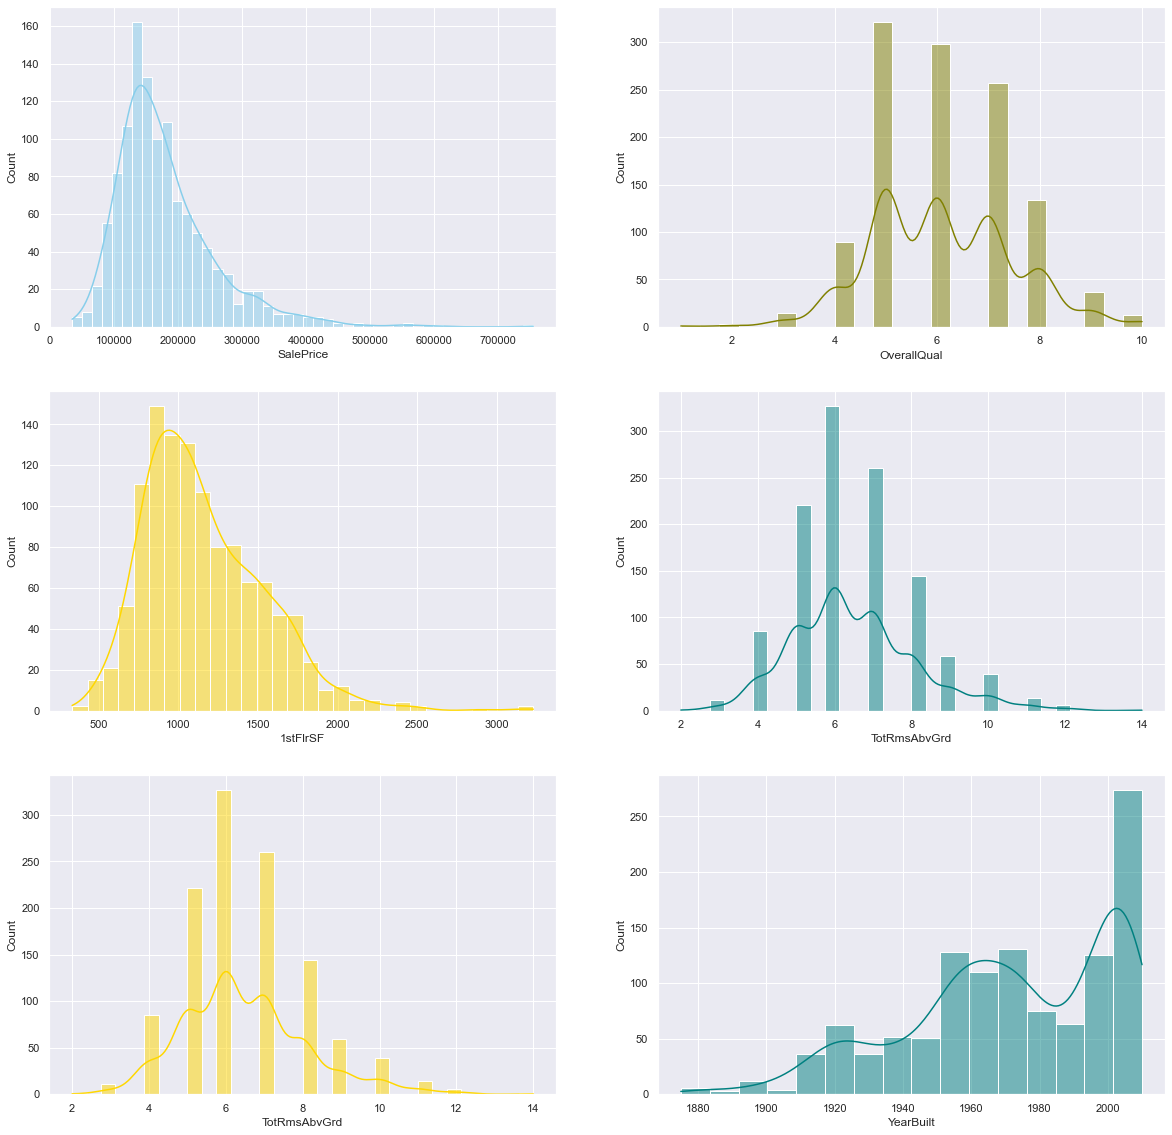

In [163]:
# coloco grey backgroud  
sns.set(style="darkgrid")
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
sns.histplot(data=Modelo, x="SalePrice", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=Modelo, x="OverallQual", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=Modelo, x="1stFlrSF", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=Modelo, x="TotRmsAbvGrd", kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=Modelo, x="TotRmsAbvGrd", kde=True, color="gold", ax=axs[2, 0])
sns.histplot(data=Modelo, x="YearBuilt", kde=True, color="teal", ax=axs[2, 1])
plt.show()

## Para cada variable independiente x :
+ Calcular el coeficiente de correlacion entre X y Y.
+ Graficar X vs Y (scatterplot) usando matplotlib.
+ Colocar el coeficiente de correlacion y colocarlo como parte del titulo de la grafico.

Correlacion entre = SalePrice  y  OverallQual = 0.7939901
Correlacion entre = SalePrice  y  1stFlrSF = 0.6162887
Correlacion entre = SalePrice  y  TotRmsAbvGrd = 0.5647069
Correlacion entre = SalePrice  y  YearBuilt = 0.5341707
Correlacion entre = SalePrice  y  LotFrontage = 0.3632916
Correlacion entre = OverallQual  y  1stFlrSF = 0.4694115
Correlacion entre = OverallQual  y  TotRmsAbvGrd = 0.4442926
Correlacion entre = OverallQual  y  YearBuilt = 0.5673129
Correlacion entre = OverallQual  y  LotFrontage = 0.2424202
Correlacion entre = 1stFlrSF  y  TotRmsAbvGrd = 0.4093182
Correlacion entre = 1stFlrSF  y  YearBuilt = 0.2920742
Correlacion entre = 1stFlrSF  y  LotFrontage = 0.4173881
Correlacion entre = TotRmsAbvGrd  y  YearBuilt = 0.122911
Correlacion entre = TotRmsAbvGrd  y  LotFrontage = 0.341005
Correlacion entre = YearBuilt  y  LotFrontage = 0.1214743


<function matplotlib.pyplot.show(close=None, block=None)>

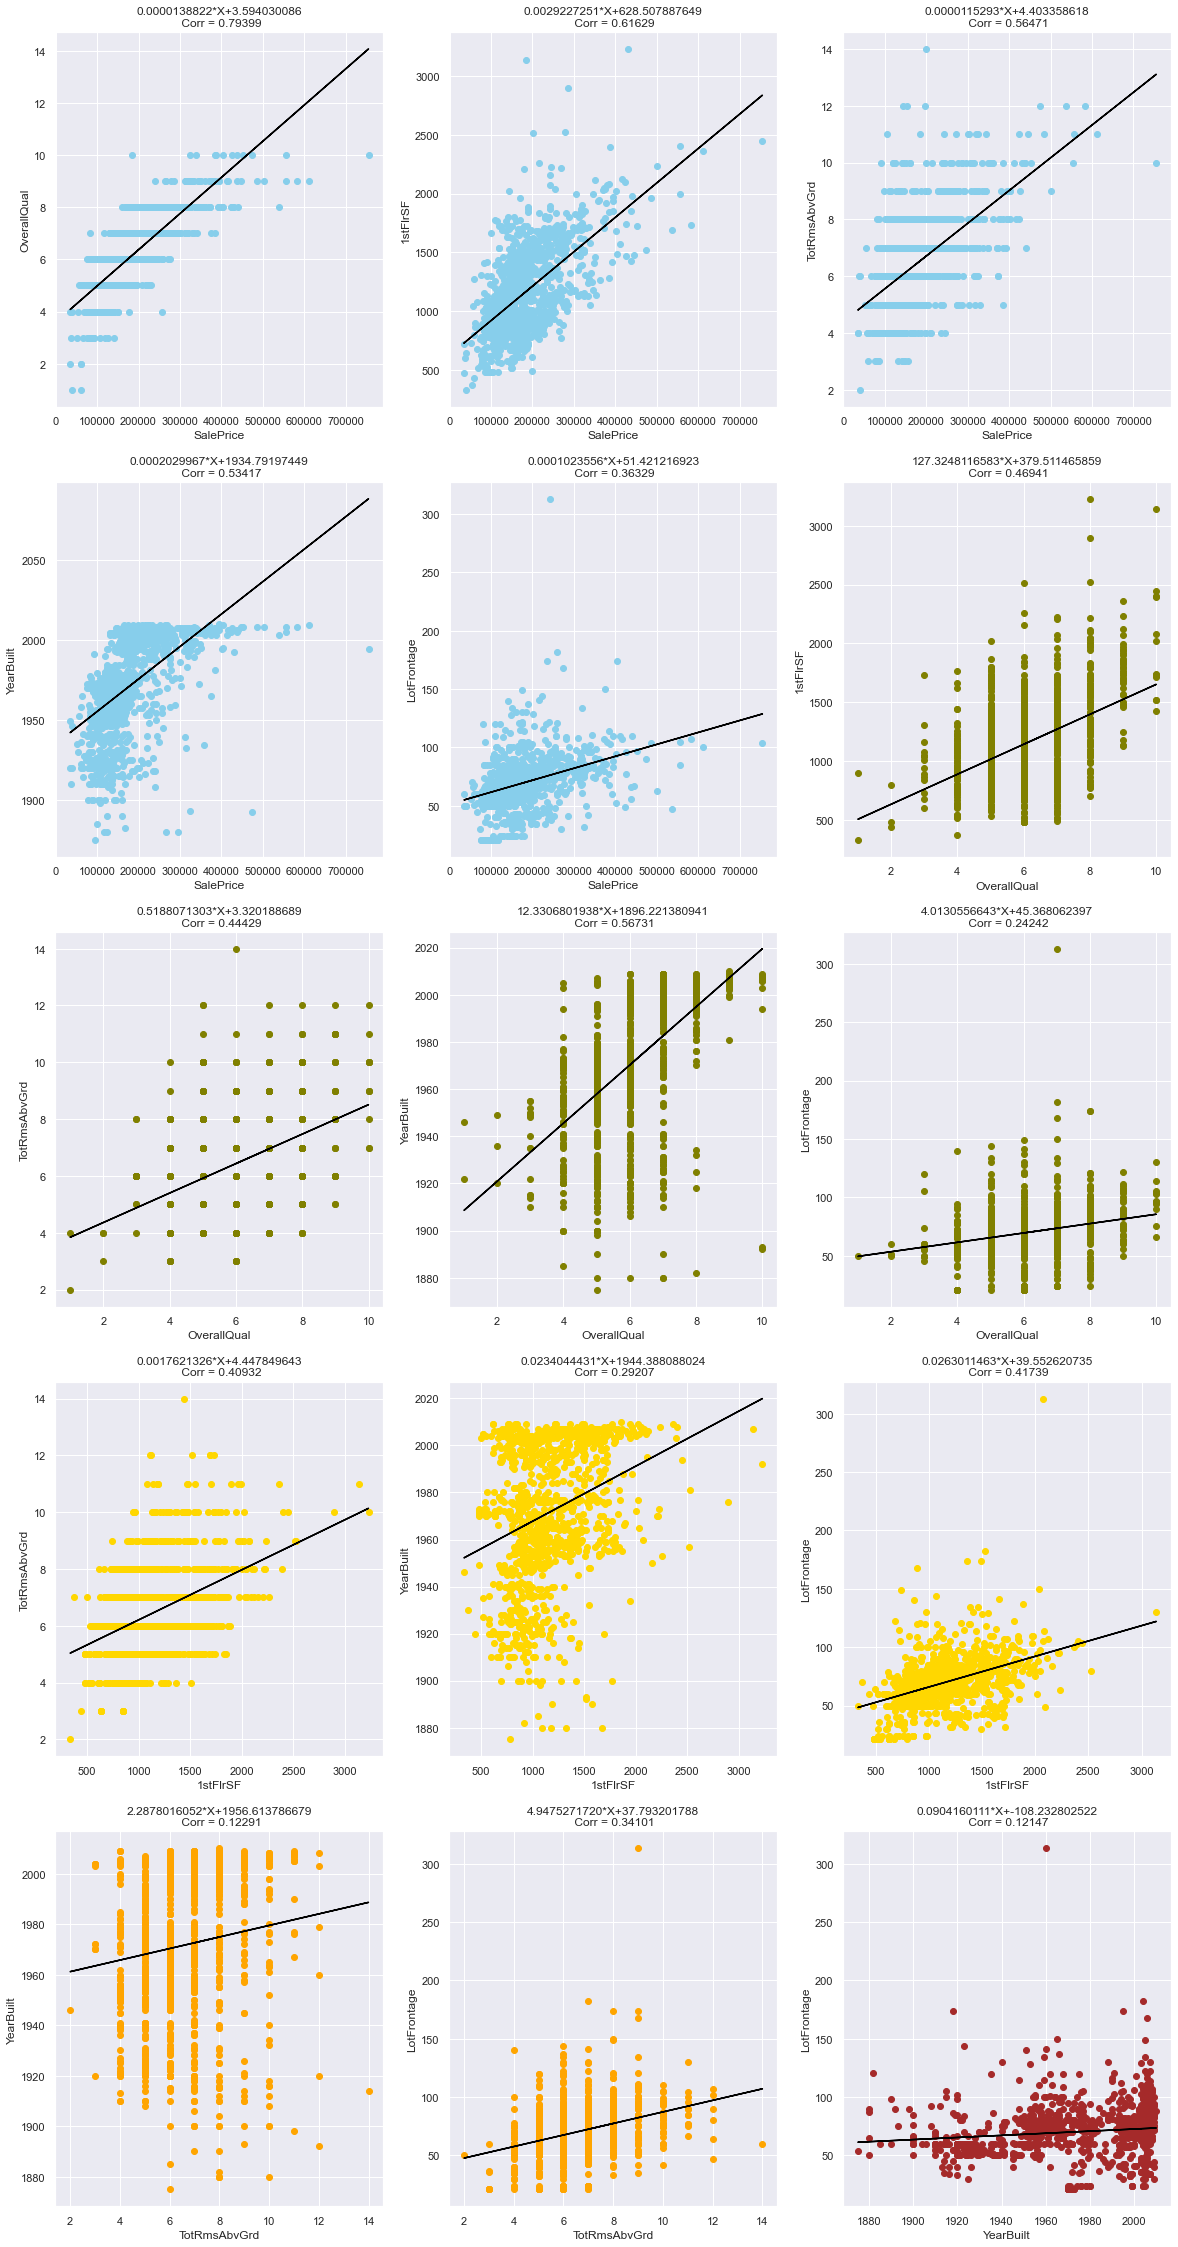

In [164]:
nombres  = list (Modelo.columns) # nombre de columnas
colors = np.array(["skyblue","olive","gold","orange","brown","magenta"]) # Colores a usar
i = 1 # contador de donde pondre la grafica
plt.figure(figsize=(20,40)) # Tamanio de la grafica
for pos1, axis1 in enumerate(nombres):   # tomar la primera columna
    for pos2, axis2 in  enumerate(nombres[pos1+1:]): # tomar la columna que sigue al punto anterior
        plt.subplot(5,3,i)
        df = Modelo[[axis1,axis2]].dropna()  # Quitar los nan
        plt.scatter(df.iloc[:,0], df.iloc[:,1], color=colors[pos1]) #scatter plot
        a, b = np.polyfit(df.iloc[:,0], df.iloc[:,1], 1) #determinar los parametros de regresion lineal
        x = df.iloc[:,0]
        plt.plot(x, a*x + b, color = "black") #Regresion Lineal con scatter-plot
        correlacion = pearsonr(x = df.iloc[:,0], y =  df.iloc[:,1])
        plt.xlabel(axis1) # en X
        plt.ylabel(axis2) # en Y
        title = str('{0:.10f}'.format(a))+"*X+"+str(round(b, 9))+"\n Corr = "+str(round(correlacion[0], 5))
        plt.title(title)
        print("Correlacion entre =",axis1, " y ",axis2,"=",round(correlacion[0], 7)) 
        i = i + 1
plt.show  


## Funcion para entrenar un modelo de regresion lineal de una variabley = B0+ B1*x.
La funcion recibe como argumentos:
+ Vector con la variable independiente x,
+ Vector con la variable dependiente y,
+ un entero epochs que indica por cuantas iteraciones entrenar el modelo.
+ un entero imprimir error cada , que nos indica cada cuantas iteraciones queremos
+ imprimir a traves de print: el numero de iteracion, el error del modelo en esa iteracion, si imprimir error cada = 10, se despliega en pantalla el error en las iteraciones:
10,20,30,40,50.
+ Escalar (learning rate): es usado como parte de la expresion matematica para actualizar en cada iteracion los parametros del modelo.     

In [225]:
def regresion (x, y, epochs, imprimir_error, learning_rate, inicialB0, inicialB1):
    # Valores iniciales
    b0 = inicialB0
    b1 = inicialB1
    
    # Resultados
    Resultado = pd.DataFrame(columns=["Errores","B0","B1"])
    
    # Matriz X , con vector 1
    matrizInicial = pd.DataFrame(x)
    matrizInicial['uno'] = 1 
    
    for i in range(0,epochs+1):
        # producto punto
        prouctoPunto = matrizInicial.dot([b0,b1])
        # calculo del error
        error = (((y - prouctoPunto)**2).sum())/(2*y.size)
        # calculo del gradiente para b0
        gradiente = (matrizInicial.multiply((prouctoPunto - y),axis="index").sum())/(y.size)
        b0 = b0 - learning_rate*gradiente[0]
        b1 = b1 - learning_rate*gradiente[1]
        new_row = {'Errores':error, 'B0':b0 , 'B1':b1}
        Resultado=Resultado.append(new_row,ignore_index=True)
        if i % imprimir_error == 0:
            print("Iteracion: ", i," --> Error",error)
    #print(Resultado)
    return Resultado


def grafica(errores ,iteration):
    plt.figure(figsize=(10,10))
    plt.scatter(iteration, errores ,color = "magenta")
    plt.xlabel('Iteracion')
    plt.ylabel('Error')
    plt.title('Grafico de Errores')
    plt.show()


def 

## Crear una funcion que nos permita visualizar con matplotlib como evoluciona el modelo entrenado en el tiempo : 
+ Crear una funcion que tome como parametro la estructura de datos conteniendo el historial de modelos ,y un valor n que indica cada cuantas iteraciones graficar el modelo resultante, por ejemplo para n=3 la funcion debe graficar la recta correspondiente al modelo junto a los datos cada 3 iteraciones, si se ejecutaron 15 iteraciones , para n = 3 se grafica el modelo de las iteraciones 3,6,9,12,15 junto con los datos de entrenamiento.
+ Utilizar las funciones del punto anterior para entrenar modelos de regresion lineal y = 0+1 x , para cada una de las variables x elegidas, basandose en las funciones
para graficar las curvas de aprendizaje y comparacion del modelo vs los datos elegir
el numero de epochs o iteraciones a entrenar el modelo(y experimentar con el)

In [ ]:
def model_evolution(parameters,n, variable):
    to_graph = np.zeros_like(parameters[0,0]*ds_train[:,0] + parameters[0,1])
    reg = np.array([])
    plt.scatter(ds_train[:,1], ds_train[:,0])
    for i in range(1,len(parameters.T)):
        if i % n == 0:
            m = parameters[0,i]
            b = parameters[1,i]
            reg = m*ds_train[:,variable] + b 
            #to_graph = np.vstack((to_graph,reg))
            plt.plot(ds_train[:,variable],reg)
            plt.xlabel('x')
            plt.ylabel('y')

## Primer modelo con coeficiente de regresion mas alto 

+ Correlacion entre = SalePrice  y  OverallQual = 0.7939901

=---------------------------------------------------=
Modelo = OverallQual / SalePrice
=---------------------------------------------------=
Iteracion:  0  --> Error 19406033664.03764
Iteracion:  1000  --> Error 1719785427.92878
Iteracion:  2000  --> Error 1398337211.792006
Iteracion:  3000  --> Error 1391377077.2971458
Iteracion:  4000  --> Error 1390117811.5365722
Iteracion:  5000  --> Error 1388967143.3267355
Iteracion:  6000  --> Error 1387823769.3718452
Iteracion:  7000  --> Error 1386685829.8685563
Iteracion:  8000  --> Error 1385553266.0892546
Iteracion:  9000  --> Error 1384426052.0427525
Iteracion:  10000  --> Error 1383304162.4484758
=---------------------------------------------------=
Resultado del modelo:
=---------------------------------------------------=
            Errores            B0           B1
0      1.940603e+10     62.496310     9.028568
1      1.933393e+10    121.768697    18.038566
2      1.926211e+10    180.922400    27.030032
3      1.919058e+10    239.957

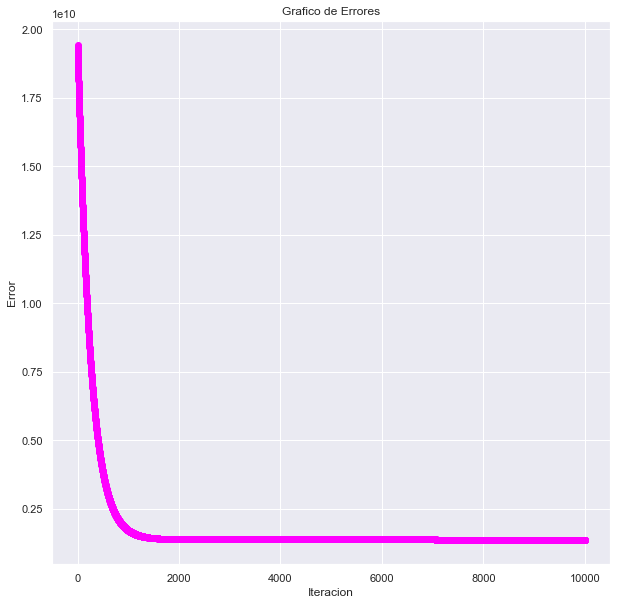

In [226]:
print ("=---------------------------------------------------=")
print ("Modelo = OverallQual / SalePrice")
print ("=---------------------------------------------------=")
b0 = 3.1050
b1 = 0.0000013
Mod1 = regresion(Modelo['OverallQual'],Modelo['SalePrice'],10000, 1000, 0.00005, b0, b1)
print ("=---------------------------------------------------=")
print ("Resultado del modelo:")
print ("=---------------------------------------------------=")
print (Mod1)
print ("=---------------------------------------------------=")
print ("Grafica de Error:")
print ("=---------------------------------------------------=")
grafica(Mod1['Errores'],Mod1.index )

## Segundo modelo con coeficiente de regresion mas alto 

+ Correlacion entre = SalePrice  y  1stFlrSF = 0.6162887

=---------------------------------------------------=
Modelo = 1stFlrSF / SalePrice
=---------------------------------------------------=
Iteracion:  0  --> Error 3816928349.2833905
Iteracion:  1000  --> Error 1954939188.9410534
Iteracion:  2000  --> Error 1954936323.8034751
Iteracion:  3000  --> Error 1954933458.9367292
Iteracion:  4000  --> Error 1954930594.3407898
Iteracion:  5000  --> Error 1954927730.015631
Iteracion:  6000  --> Error 1954924865.9612281
Iteracion:  7000  --> Error 1954922002.177555
Iteracion:  8000  --> Error 1954919138.6645858
Iteracion:  9000  --> Error 1954916275.422296
Iteracion:  10000  --> Error 1954913412.4506586
=---------------------------------------------------=
Resultado del modelo:
=---------------------------------------------------=
            Errores          B0           B1
0      3.816928e+09  162.922031  4999.972163
1      2.082426e+09  153.220161  4999.965763
2      1.963670e+09  150.681556  4999.964972
3      1.955540e+09  150.017301  4999.96

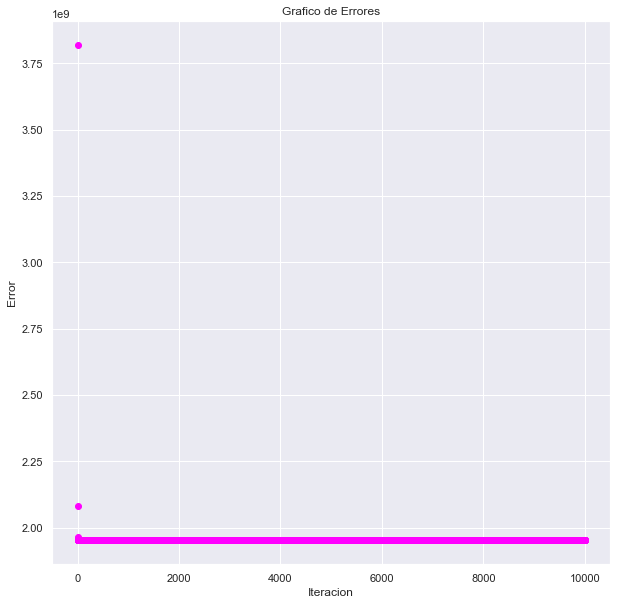

In [229]:
print ("=---------------------------------------------------=")
print ("Modelo = 1stFlrSF / SalePrice")
print ("=---------------------------------------------------=")
b0 = 200
b1 = 5000
Mod2 = regresion(Modelo['1stFlrSF'], Modelo['SalePrice'], 10000, 1000, 0.0000005 , b0, b1)
print ("=---------------------------------------------------=")
print ("Resultado del modelo:")
print ("=---------------------------------------------------=")
print (Mod2)
print ("=---------------------------------------------------=")
print ("Grafica de Error:")
print ("=---------------------------------------------------=")
grafica(Mod2['Errores'],Mod2.index )

[[7.]
 [6.]
 [7.]
 ...
 [7.]
 [8.]
 [6.]]
Coeficiente: [[1.38822386e-05]]
Interseccion: [3.59403009]
Coefficient of determination: 0.61


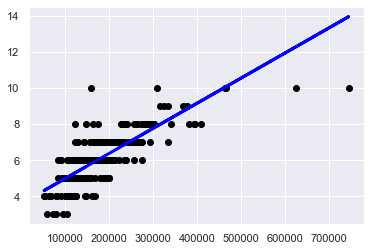

In [282]:
# Create linear regression object
y = pd.DataFrame(Modelo['SalePrice']).values
x = pd.DataFrame(Modelo['OverallQual']).values
print(x)
modeloLineal = linear_model.LinearRegression()
modeloLineal.fit(y,x)
### print regression parameters
print('Coeficiente:', modeloLineal.coef_)
print('Interseccion:', modeloLineal.intercept_)

x_test = pd.DataFrame(Validacion['SalePrice']).values
y_test = pd.DataFrame(Validacion['OverallQual']).values
diabetes_y_pred = modeloLineal.predict(x_test)

#print(diabetes_y_pred)
print('Coefficient of determination: %.2f'% r2_score(y_test, diabetes_y_pred))

plt.scatter(x_test, y_test ,color='black')
plt.plot(x_test, diabetes_y_pred, color='blue', linewidth=3)

plt.show()
